# Демонстрация метрики для классификации

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

C:\Users\pc\AppData\Local\Temp\ipykernel_16284\1328233346.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Стандартные библиотеки для анализа
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import base_pipe, BalanceCover

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab
import shap

print('pandas: ', pd.__version__)
print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

pandas:  1.5.3
sklearn:  1.2.2
xgboost:  1.7.4
matplotlib:  3.7.1
autobinary:  1.0.11


In [5]:
sample = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [6]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

target = ['Survived']

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [8]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


In [9]:
prep_pipe.fit(X_train, y_train)

new_X_train = prep_pipe.transform(X_train)
new_X_valid = prep_pipe.transform(X_valid)

In [10]:
# создаем экземпляр класса XGBClassifier
xgb_model = xgb.XGBClassifier(
    eta=0.01,
    n_estimators=800,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth = 6,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42)

In [11]:
xgb_model.fit(new_X_train, y_train);

## 1. Кастомная метрика

In [12]:
df_train = pd.DataFrame()
df_train['target'] = y_train
df_train['proba'] = xgb_model.predict_proba(new_X_train)[:, 1]
df_train = df_train.sort_values('proba', ascending=False).reset_index(drop=True)

df_train.head(2)

,target,proba
0,1,0.992009
1,1,0.989195


In [13]:
df_valid = pd.DataFrame()
df_valid['target'] = y_valid
df_valid['proba'] = xgb_model.predict_proba(new_X_valid)[:, 1]
df_valid = df_valid.sort_values('proba', ascending=False).reset_index(drop=True)

df_valid.head(2)

,target,proba
0,1,0.991601
1,1,0.990084


### 1.1 TRAIN - Накапливаемые статистики

In [14]:
metr_train = BalanceCover(df_train, target='target')

Всего записей в выборке:  623
Всего таргетов в выборке:  239

Баланс классов:  38.36  %


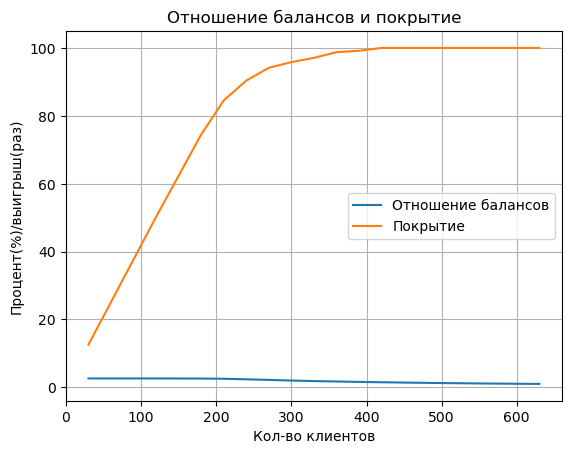

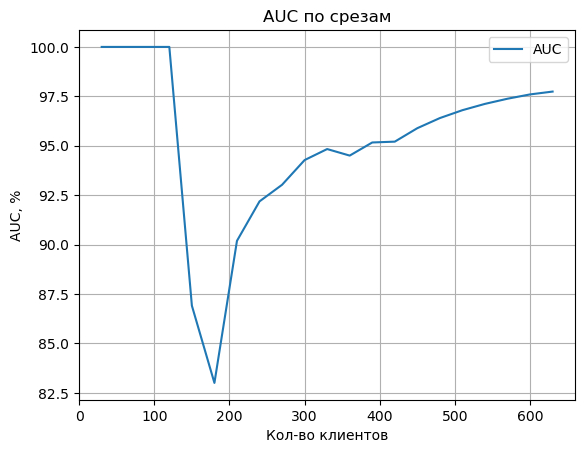

In [15]:
metr_train.calc_scores(30, df_train.shape[0])

metr_train.sample_describe()
metr_train.plot_scores()

In [16]:
metr_train.output

,start_bucket,end_bucket,turget_in_bucket,bucket_bal (%),coverage (%),base_bal (%),bucket_bal/base_bal,auc
0,0,30,30,100.000000,12.552301,38.362761,2.606695,100.000000
1,0,60,60,100.000000,25.104603,38.362761,2.606695,100.000000
2,0,90,90,100.000000,37.656904,38.362761,2.606695,100.000000
3,0,120,120,100.000000,50.209205,38.362761,2.606695,100.000000
4,0,150,149,99.333333,62.343096,38.362761,2.589317,86.912752
5,0,180,178,98.888889,74.476987,38.362761,2.577731,83.005618
6,0,210,202,96.190476,84.518828,38.362761,2.507392,90.191832
7,0,240,216,90.000000,90.376569,38.362761,2.346025,92.187500
8,0,270,225,83.333333,94.142259,38.362761,2.172245,93.027160
9,0,300,229,76.333333,95.815900,38.362761,1.989777,94.277016


### 1.2 TRAIN - Статистики по бакетам

Всего записей в выборке:  623
Всего таргетов в выборке:  239

Баланс классов:  38.36  %


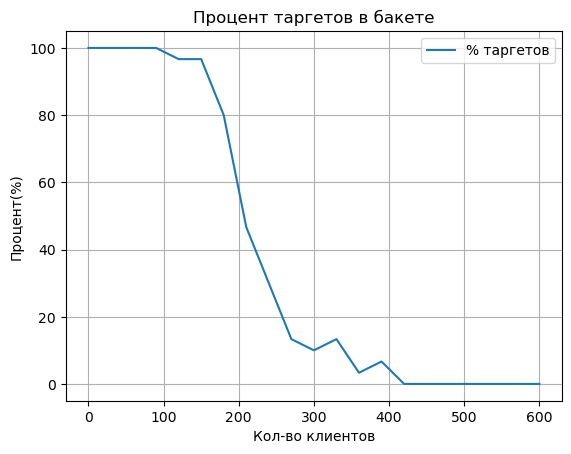

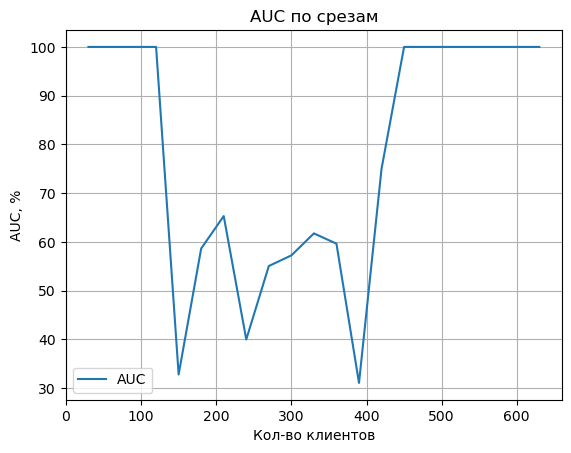

In [17]:
metr_train.calc_scores_2(30, df_train.shape[0])

metr_train.sample_describe()
metr_train.plot_scores_2()

In [18]:
metr_train.output2

,start_bucket,end_bucket,target_in_bucket,bucket_bal (%),coverage (%),base_bal (%),bucket_bal/base_bal,auc
0,0,30,30,100.000000,12.552301,38.362761,2.606695,100.000000
1,30,60,30,100.000000,12.552301,38.362761,2.606695,100.000000
2,60,90,30,100.000000,12.552301,38.362761,2.606695,100.000000
3,90,120,30,100.000000,12.552301,38.362761,2.606695,100.000000
4,120,150,29,96.666667,12.133891,38.362761,2.519805,32.758621
5,150,180,29,96.666667,12.133891,38.362761,2.519805,58.620690
6,180,210,24,80.000000,10.041841,38.362761,2.085356,65.277778
7,210,240,14,46.666667,5.857741,38.362761,1.216457,39.955357
8,240,270,9,30.000000,3.765690,38.362761,0.782008,55.026455
9,270,300,4,13.333333,1.673640,38.362761,0.347559,57.211538


### 1.3 TEST - Накапливаемые статистики

In [19]:
metr_valid = BalanceCover(df_valid, target='target')

Всего записей в выборке:  268
Всего таргетов в выборке:  103

Баланс классов:  38.43  %


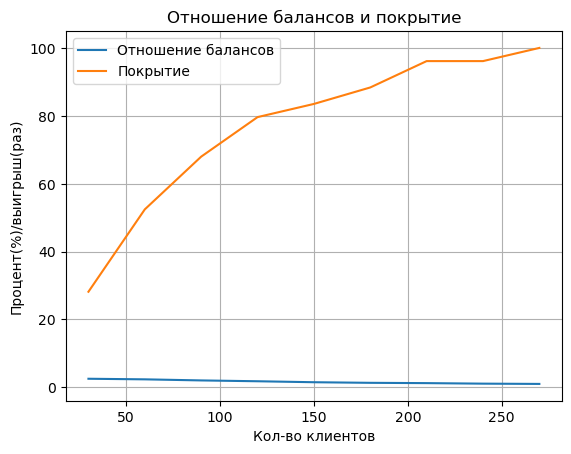

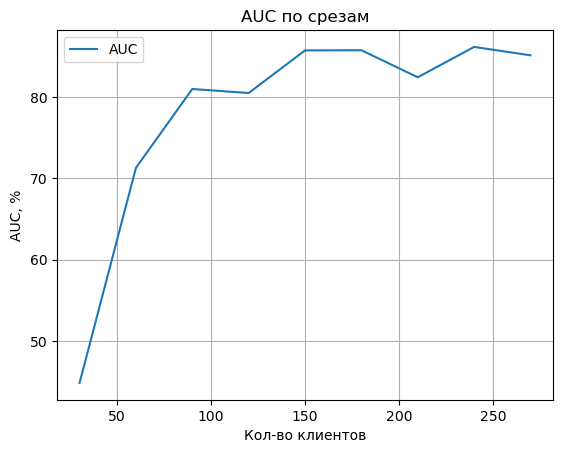

In [20]:
metr_valid.calc_scores(30, df_valid.shape[0])

metr_valid.sample_describe()
metr_valid.plot_scores()

In [21]:
metr_valid.output

,start_bucket,end_bucket,turget_in_bucket,bucket_bal (%),coverage (%),base_bal (%),bucket_bal/base_bal,auc
0,0,30,29,96.666667,28.155340,38.432836,2.515210,44.827586
1,0,60,54,90.000000,52.427184,38.432836,2.341748,71.296296
2,0,90,70,77.777778,67.961165,38.432836,2.023732,81.000000
3,0,120,82,68.333333,79.611650,38.432836,1.777994,80.503851
4,0,150,86,57.333333,83.495146,38.432836,1.491780,85.746730
5,0,180,91,50.555556,88.349515,38.432836,1.315426,85.769848
6,0,210,99,47.142857,96.116505,38.432836,1.226630,82.441532
7,0,240,99,41.250000,96.116505,38.432836,1.073301,86.177377
8,0,270,103,38.148148,100.000000,38.432836,0.992593,85.145631


### 1.4 TEST - Статистики по бакетам

Всего записей в выборке:  268
Всего таргетов в выборке:  103

Баланс классов:  38.43  %


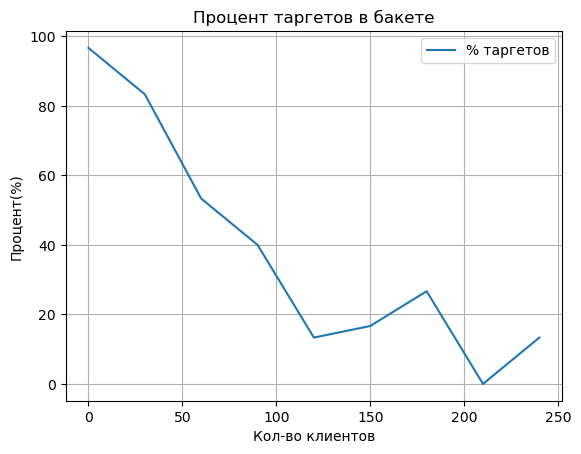

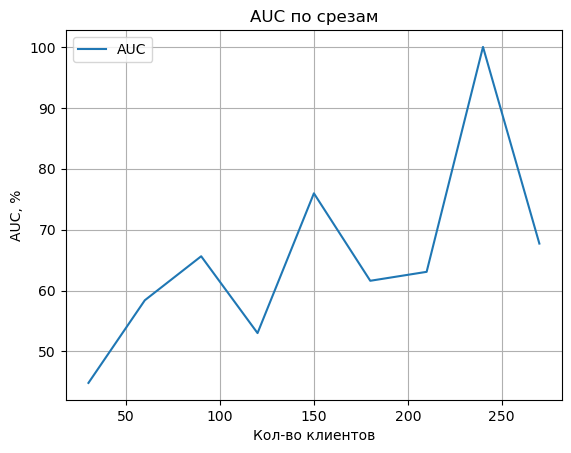

In [22]:
metr_valid.calc_scores_2(30, df_valid.shape[0])

metr_valid.sample_describe()
metr_valid.plot_scores_2()

In [23]:
metr_valid.output2

,start_bucket,end_bucket,target_in_bucket,bucket_bal (%),coverage (%),base_bal (%),bucket_bal/base_bal,auc
0,0,30,29,96.666667,28.155340,38.432836,2.515210,44.827586
1,30,60,25,83.333333,24.271845,38.432836,2.168285,58.400000
2,60,90,16,53.333333,15.533981,38.432836,1.387702,65.625000
3,90,120,12,40.000000,11.650485,38.432836,1.040777,53.009259
4,120,150,4,13.333333,3.883495,38.432836,0.346926,75.961538
5,150,180,5,16.666667,4.854369,38.432836,0.433657,61.600000
6,180,210,8,26.666667,7.766990,38.432836,0.693851,63.068182
7,210,240,0,0.000000,0.000000,38.432836,0.000000,100.000000
8,240,270,4,13.333333,3.883495,38.432836,0.346926,67.708333
